In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import os

#variable
SUMMARY = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv'
TSS = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Merged_Causality_TSS_TSS.tab'
ANNOT =  "/storage/mgymrek/gtex/annotations/encode/"
ENHANC = ["Strong_Enhancer","Weak_Enhancer"]

sep='"\t"'
#command = "cat %s |awk -F'\t' '{print $1%s$2%s$75%s$4}' > all_analyzed_strs.tab"%(SUMMARY, sep,sep,sep)
#value = os.system(command)

In [2]:
#All STRs
allstrs = pd.read_csv(SUMMARY, sep='\t')
allstrs['locus']=allstrs.apply(lambda x: x["chrom"]+":"+str(x["str.start"]), 1)
estrs = allstrs.loc[allstrs['E.tissues']>=1] 
print(allstrs.shape, 'All loci:', len(set(allstrs['locus'])) , estrs.shape, 'eSTR loci:',len(set(estrs['locus'])))


#enhancers
enhancer = {
    'Strong_E': os.path.join(ANNOT,"%s_GM12878.bed"%ENHANC[0]),
    'Weak_E': os.path.join(ANNOT,"%s_GM12878.bed"%ENHANC[1])
            }
#intersect with strong enhancers
command = "bedtools intersect -a all_analyzed_strs.tab -b %s > Intersect.bed"%enhancer['Strong_E']
value = os.system(command)
enhancer['inter_strong'] = pd.read_csv('Intersect.bed', sep='\t', names=["chrom","start","end","gene"]).drop_duplicates()
feature_loci = set(enhancer['inter_strong'].apply(lambda x: x["chrom"]+":"+str(x["start"]), 1))
allstrs['inter_strong'] = np.where(allstrs["locus"].isin(feature_loci), 1, 0)


#intersect with weak enhancers
command = "bedtools intersect -a all_analyzed_strs.tab -b %s > Intersect.bed"%enhancer['Weak_E']
value = os.system(command)
enhancer['inter_weak'] = pd.read_csv('Intersect.bed', sep='\t', names=["chrom","start","end","gene"]).drop_duplicates()
feature_loci = set(enhancer['inter_weak'].apply(lambda x: x["chrom"]+":"+str(x["start"]), 1))
allstrs['inter_weak'] = np.where(allstrs["locus"].isin(feature_loci), 1, 0)

(307187, 78) All loci: 125758 (25619, 78) eSTR loci: 20192


In [8]:
enhan = allstrs.loc[(allstrs['inter_strong']==1)|(allstrs['inter_weak']==1)].copy()
print('All STRs at enhancers', len(set(enhan['locus'])), enhan.loc[enhan['E.tissues']>=1].shape,'eSTRs at enhancers',len(set(enhan.loc[enhan['E.tissues']>=1]['locus'])) )

Eenhan = enhan.loc[enhan['E.tissues']>=1].copy()
Motifs = list(set(Eenhan['motif']))

locus=len(set(allstrs['locus']))
eSTR=len(set(estrs['locus']))
locus_enh = len(set(enhan['locus']))
estr_enh_locus = len(set(enhan.loc[enhan['E.tissues']>=1]['locus']))  
odd_enhancer, pv_enhancer = ss.fisher_exact([[estr_enh_locus,eSTR-estr_enh_locus],[locus_enh-estr_enh_locus, locus-eSTR-(locus_enh-estr_enh_locus)]])
print('Enrichment of eSTRs at enhancer regions',odd_enhancer, pv_enhancer)

odds=[]
pval=[]
count=[]

#overall enrichment #66 eSTRs motifs 
for motif in Motifs:
    me = Eenhan.loc[Eenhan['motif']==motif].shape[0]
    mne= Eenhan.shape[0] - me
    nme= enhan.loc[enhan['motif']==motif].shape[0]-me
    nmne=enhan.shape[0]-enhan.loc[enhan['motif']==motif].shape[0]-(mne) 
    #print([me,mne],[nme,nmne])
    
    OR, p = ss.fisher_exact([[me,mne],[nme,nmne]])
    
    odds.append(np.log2(OR))
    pval.append(p) #(-np.log10(p))
    count.append((enhan.loc[enhan['motif']==motif].shape[0], me))

data=pd.DataFrame.from_dict({'motif':Motifs, 'OR':odds, 'pvalue':pval, 'Counts':count}).sort_values('pvalue')
data.index=list(data['motif'])
data

All STRs at enhancers 7924 (2204, 80) eSTRs at enhancers 1673
Enrichment of eSTRs at enhancer regions 1.4353035443698845 2.105432869238656e-34


,Counts,OR,motif,pvalue
AC,"(6321, 515)",-0.256218,AC,0.000676
AT,"(530, 66)",0.501916,AT,0.011908
CCCCGG,"(6, 3)",3.304519,CCCCGG,0.012574
AAC,"(458, 56)",0.469271,AAC,0.027357
AAG,"(66, 1)",-2.723278,AAG,0.029383
AACC,"(28, 6)",1.430757,AACC,0.038921
AGGCGG,"(15, 4)",1.845212,AGGCGG,0.042789
CCCCG,"(65, 11)",1.010929,CCCCG,0.048181
CCCCCG,"(16, 4)",1.719615,CCCCCG,0.053023
AGGG,"(73, 2)",-1.850402,AGGG,0.064372


/usr/lib64/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


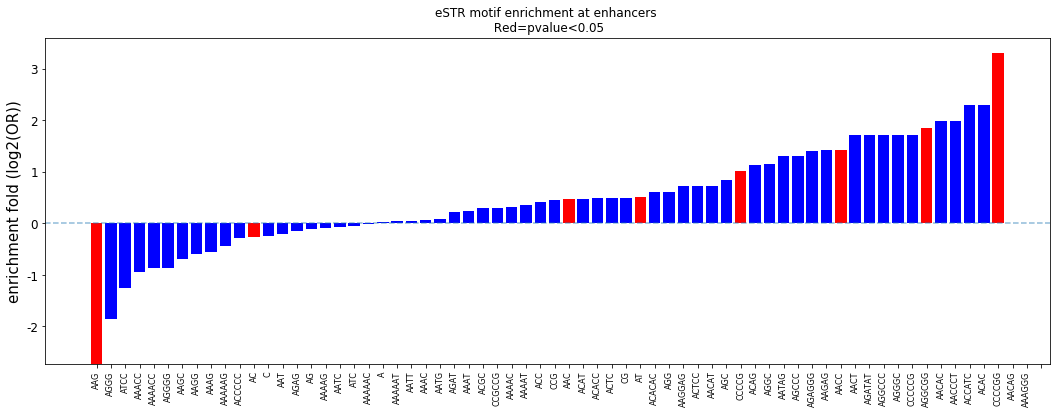

In [36]:
data=data.sort_values('OR',ascending=True)
data['color']= data['pvalue'].apply(lambda x: 'r' if x<=0.05 else 'b')
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111)

ax.bar([i for i in range(data.shape[0])],data['OR'], color=list(data['color']))
ax.set_xticks([i for i in range(data.shape[0]+1)])

#plt.xticks([x for x in range(len(ordered_All))],[x[0] for x in ordered_All], rotation='vertical')

ax.set_xticklabels(list(data.index), size=8, rotation='vertical');
ax.set_ylabel("enrichment fold (log2(OR))", size=15)

ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);
ax.legend(loc="upper center", frameon=False);
plt.axhline(y=np.log2(1), xmin=0, xmax=1, hold=None, alpha=0.5, ls='--')
plt.title("eSTR motif enrichment at enhancers \n Red=pvalue<0.05")
plt.show()

In [21]:
data.loc[(data['OR']>0)&(data['pvalue']<0.05)]

,Counts,OR,motif,pvalue
AT,"(530, 66)",0.501916,AT,0.011908
CCCCGG,"(6, 3)",3.304519,CCCCGG,0.012574
AAC,"(458, 56)",0.469271,AAC,0.027357
AACC,"(28, 6)",1.430757,AACC,0.038921
AGGCGG,"(15, 4)",1.845212,AGGCGG,0.042789
CCCCG,"(65, 11)",1.010929,CCCCG,0.048181
